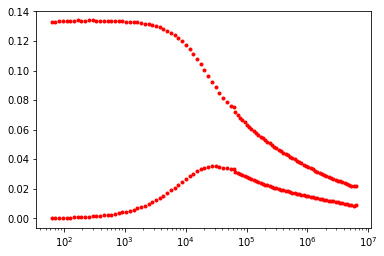

In [ ]:
# In this notebook the relaxation time distribution is extracted from the AC susceptibility measurement 
# of a sample of (pseudo-)superparamagnetic nanoparticles
# by a regularized numerical inversion using the Debye-function as model function
# The results are published in: 
# "Relating Magnetic Properties and High Hyperthermia Performance of Iron Oxide Nanoflowers"
# https://doi.org/10.1021/acs.jpcc.7b11255

#==============================================================================
# Import of used packages
from numpy.linalg import slogdet
import numpy as np
import pylab as py
from scipy.optimize import nnls
#==============================================================================
# Import of the data
# column 1: rotational frequency omega = 2*pi*f [rad/s]
# column 2/3: real part of complex susceptibility/measurement uncertainty (we assumed a constant value for sdi)
# column 4/5: imaginary part of complex susceptibility/measurement uncertainty (we assumed a constant value for sdii)

wList,mi,sdi,mii,sdii=np.genfromtxt("../data/NF-ACS_data.txt", unpack=True, usecols = (0, 1, 2, 3, 4), skip_header=0)

NH=len(wList)

sd=np.hstack([sdi,sdii])
m=np.hstack([mi,mii]) 
wList2=np.hstack([wList,wList]) 

sd_sq   = pow(sd,2)         
sdnorm  = 1/sd 
sdnorm = NH * sdnorm/sdnorm.sum()
sdmat = np.diag(sdnorm)
sdcol  = sdnorm[:,np.newaxis]            

M = m.dot(sdmat) # normalize data by sigma

#==============================================================================
# Definition of characteristic relaxation time distribution

N=151 # number of points of moment distribution
tcList = np.logspace(-9,0,N)  # Moment distrbution with lognormal spacing

wcList=1./tcList # corresponding relaxation frequency distribution
wcList2 = np.hstack([1./tcList,1./tcList])

#==============================================================================
# generate list for regularization parameter a

Na=200
aList=np.logspace(-5,5,Na)

#==============================================================================
# Plot data

py.plot(wList,mi, color='r', marker='.', ls='None', label='Observed') # real part
py.plot(wList,mii, color='r', marker='.', ls='None', label='Observed') # imaginary part
py.xscale('log')
py.show()
print('Figure 1: data') 

#==============================================================================
# regularization matrices

L=0.5*(-1*np.eye(N,k=-1)+2*np.eye(N,k=0)-1*np.eye(N,k=1))
L[0,1] = 0
L[N-1,N-2] = 0

#==============================================================================
# Definition of function to generate the system matrix

def real(tc, w): # real part of complex susceptibility
    return 1 / (1 + pow(w*tc,2))

def imag(tc, w): # imaginary part of complex susceptibility
    return w*tc / (1 + pow(w*tc,2))

#==============================================================================
# Inversion of data 

evList=[] 
prList=[]

X = np.hstack([M, np.zeros(N)]) 

wListmat=np.tile(wList,(N,1)).T
tcListmat=np.tile(tcList,(NH,1))

K1 = real(wListmat,tcListmat)
K2 = imag(wListmat,tcListmat)
K = np.vstack([K1,K2])

B = (K.T).dot(K*pow(sdcol,2))  

for ai in range(len(aList)):     
    # stacking of matrices            
    C = np.vstack([K*sdcol,np.sqrt(2*aList[ai])*L])              
    
    # Fit: non-negative constraint
    pr,resnorm=nnls(C,X)    
    
    # determine chisquare            
    Ifit=K.dot(pr)    
    chisq=(pow(m-Ifit,2)/sd_sq).sum()              

    # calculation of evidence
    S=sum(pow(L.dot(pr),2))
    Lsq=pow(L,2)
    U=2*Lsq+B/aList[ai] 
    detsign,rlogdet=slogdet(U)
    G=-aList[ai]*S-0.5*chisq            
    evidence=(G-0.5*rlogdet) # log of evidence    
        
    evList.append(evidence)       
    prList.append(pr)     

MAX=evList.index(max(evList)) # find maximal evidence
prM=prList[MAX] # relaxation time distribution for which highest evidence was calculated

prList2=np.reshape(prList,(Na,N))         

wcListmat=np.tile(wcList,(N,1)).T
tcListmat2=np.tile(tcList,(N,1))

Kfit1 = real(wcListmat,tcListmat2)
Kfit2 = imag(wcListmat,tcListmat2)
Kfit=np.vstack([Kfit1,Kfit2])

fitM=Kfit.dot(prM) # fitting curve (reconstructed for prM)

#==============================================================================
# Plots

py.plot(tcList,prM)
py.xscale('log')
py.show()
print('Figure 2: characteristic relaxation time distribution prM')

py.figure()
for i in range(Na):
    py.xscale('log')
    py.plot(tcList, prList2[i, :])
py.show()  
print('Figure 3: all distributions')
    
py.errorbar(wList2,m,sd,color='r',marker='.',ls='None',label='Observed')
py.plot(wcList2,fitM)
py.xscale('log')
py.show()
print('Figure 4: Data (red points) and fit (blue line)')

py.plot(aList,evList,'k+')
py.xscale('log')
py.show()
print('Figure 5: evidence vs alpha.')